# Predicting Daily Alcohol Consumption from Liver Function Tests

* The goal of this analysis is to predict how much an individual drinks given their liver function tests and to assess which tests are more important in predicting amount of drinks reported (under an assumption that patient self-reported drinking amount is about the same as the actual drinking amount).
* Complex tests and methods may not be suitable in clinical settings - simple bloodwork and guidance to medical staff is the ideal final result
* Generalized linear models can help identify the imporance of liver function tests in predicting the role of alcohol in liver disease due to their simplicity and explainability
* The dataset includes 5 liver function tests which are indicators of liver damage

In [1]:
!pip install -U -q pandas numpy matplotlib seaborn scipy scikit-learn statsmodels SciencePlots

In [83]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

import statsmodels
from statsmodels.stats import descriptivestats as ds

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, confusion_matrix, make_scorer, balanced_accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline

In [92]:
for module in [pd, np, matplotlib, sns, scienceplots, statsmodels, sklearn]:
    try:
        print(module.__name__ + " == " + module.__version__)
    except:
        print(module.__name__)

pandas == 2.2.3
numpy == 1.26.4
matplotlib == 3.10.0
seaborn == 0.13.2
scienceplots
statsmodels == 0.14.4
sklearn == 1.6.1


In [3]:
# define graphing styles

plt.style.use(['science', 'no-latex', 'scatter', 'high-vis'])

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load and Process Data

In [7]:
# import the dataset

liver_disorders = pd.read_csv('../data/bupa.data', header=None)
# original column names: 'mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks', 'selector'
# I will rename these to tje modern liver function test name abbreviations

liver_disorders.columns = ['mcv', 'alp', 'alt', 'ast', 'ggt', 'drinks', 'selector']
data_features = ['mcv', 'alp', 'alt', 'ast', 'ggt']
target = 'drinks'

n_samples = len(liver_disorders)
print(f"n_samples = {n_samples}")

# drop "selector" column; this column indicates a train/test split but we will use cross-validation to obtain test error
liver_disorders = liver_disorders.drop('selector', axis=1)

n_samples = 345


## Exploratory Data Analysis

In [8]:
print(f"Values of drinks variable: {liver_disorders['drinks'].unique().tolist()}")

Values of drinks variable: [0.0, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 16.0, 20.0, 15.0]


* It looks like there's a 0.5 drinks in the dataset
* The data origin does not specify what this means. It could mean that the person reported consuming between 0 and 1 drinks but we can't be certain. 

In [9]:
# summarize statistics 

ds.describe(liver_disorders, stats=['missing', 'mean', 'median', 'mode', 'std', 'percentiles']).round(3).T

,missing,mean,median,mode,mode_freq,std,1%,5%,10%,25%,50%,75%,90%,95%,99%
mcv,0.0,90.159,90.0,91.0,0.119,4.448,79.88,83.0,85.0,87.0,90.0,93.0,96.0,98.0,100.00
alp,0.0,69.870,67.0,63.0,0.038,18.348,37.88,44.0,48.4,57.0,67.0,80.0,94.6,102.0,122.56
alt,0.0,30.406,26.0,17.0,0.049,19.512,9.00,12.0,15.0,19.0,26.0,34.0,51.6,66.4,108.60
ast,0.0,24.643,23.0,20.0,0.081,10.064,11.00,14.0,15.0,19.0,23.0,27.0,35.0,43.0,66.24
ggt,0.0,38.284,25.0,14.0,0.052,39.255,6.00,9.0,11.0,15.0,25.0,46.0,82.0,114.8,203.00
drinks,0.0,3.455,3.0,0.5,0.313,3.338,0.00,0.5,0.5,0.5,3.0,6.0,8.0,10.0,15.56


* Target variable `drinks` counts consumption of alcohol as the number of half-pint drinks per day, as reported
    * Poisson R.V. could be a candidate for modeling the target variable but there are a few problems: 1. variance is about 3x higher than the mean which means that there's overdispersion which violates Poisson distribution assumption and 2. drinks is a self-reported metric and may be not be an exact measure of alcohol consumption so modeling it as Poisson may cause difficulties and 3. the target feature includes 0.5 which not a discrete value (we could convert this to a discrete value by multiplying the target feature by 2 though but that would have implications on the interpretation later on). Negative Binomial Regression may be able to overcome the dispersion issue.
    * Gamma distribution with $\alpha\leq 1$ could be another candidate. Similar to Poisson, it models events in a fixed period in time but it models continuous events. Moreover, parameter $\alpha$ helps overcome issues with dispersion because it essentially allows flexibility for convexity of its PDF. Unfortunately, Gamma regression is undefined when $y_i=0$ and our dataset contains instances when a person reports not drinking so it cannot be used in our model without removing 0s or manipulating data too much
    * Linear regression could work but it may yield negative or fraction values. We could add a post-processing function to handle negative values and fraction values could be true to the variable since the target variable is likely an approximation and it's unlikely that patients measure out their drinks exactly
    * Binary or categorical variable can model our target variable as well - we can define a threshold of drinks that separates individuals who drink a little vs drink a lot. The two issues with this method include: 1. there is no definitive way to segment the target variable and 2. simplification of the task may lead to information loss.
 

Our dataset contains 5 predictor variables and one target variable but there is no documentation regarding if the dataset contains only tests of individuals who have liver disease or all individuals. Let's cross reference the values we have with known normal ranges  (*In medicine, the 2.5th and 97.5th percentiles are often used to define a normal range.*)

| Test | Normal Range | 
| ---- | ------------ | 
| MCV  | [80-95 fl](https://www.ucsfhealth.org/medical-tests/cbc-blood-test) | 
| ALP  | [44 - 147 UI/L](https://www.ucsfhealth.org/medical-tests/alp---blood-test) | 
| ALT  | [4 - 36 UI/L](https://www.ucsfhealth.org/medical-tests/alanine-transaminase-(alt)-blood-test) | 
| AST  | [8 - 33 UI/L](https://www.ucsfhealth.org/medical-tests/aspartate-aminotransferase-(ast)-blood-test) | 
| GGT  | [5 - 40 U/L](https://www.ucsfhealth.org/medical-tests/gamma-glutamyl-transferase-(ggt)-blood-test) | 



In [10]:
# define the reference ranges for each test
ref_ranges = {
    'mcv': (80, 95),
    'alp': (44, 147),
    'alt': (4, 36),
    'ast': (8, 33),
    'ggt': (5, 40)
}

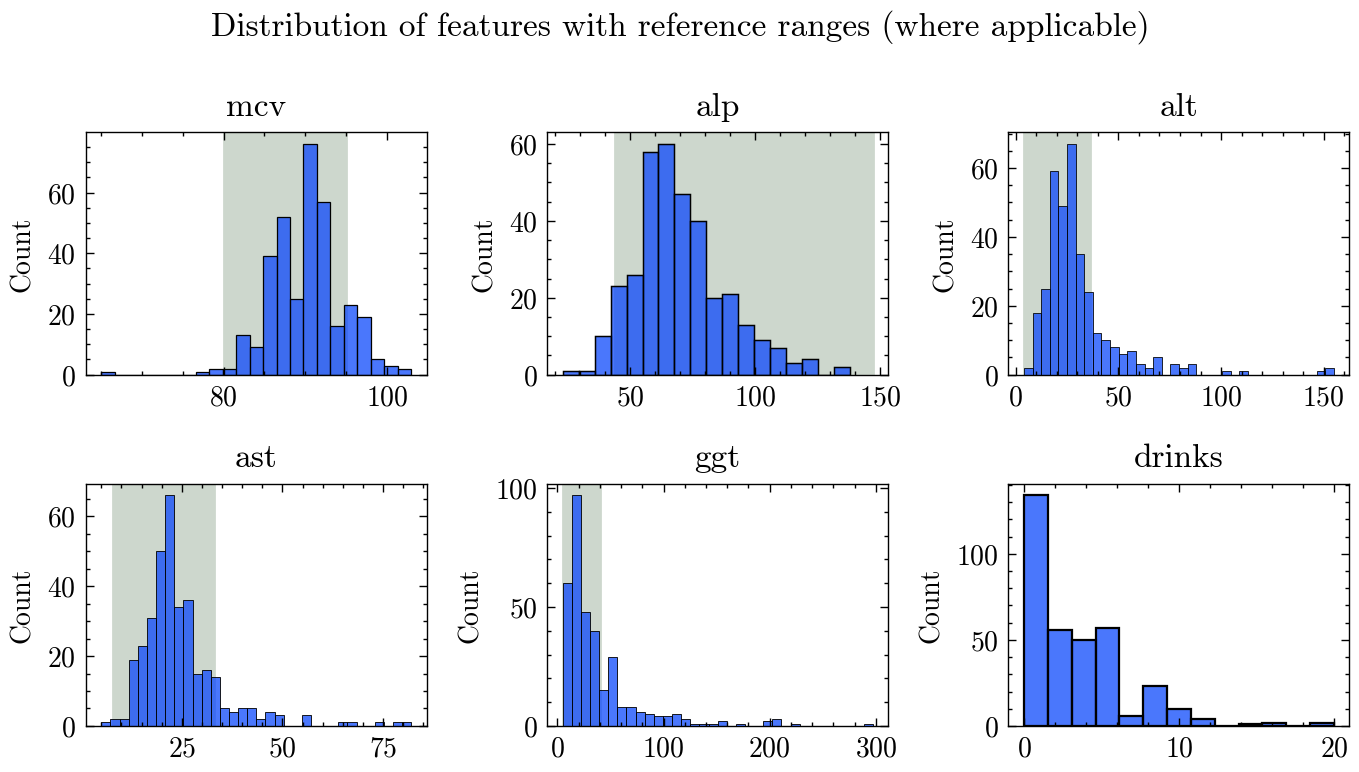

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7, 4))

for i, feature in enumerate(data_features[:3]):
    axes[0][i].axvspan(ref_ranges[feature][0], ref_ranges[feature][1], color='#cdd7cd')
    sns.histplot(data=liver_disorders, x=feature, ax=axes[0][i])
    axes[0][i].set_title(feature)
    axes[0][i].set_xlabel('')

for i, feature in enumerate(data_features[3:]):
    axes[1][i].axvspan(ref_ranges[feature][0], ref_ranges[feature][1], color='#cdd7cd')
    sns.histplot(data=liver_disorders, x=feature, ax=axes[1][i])
    axes[1][i].set_title(feature)
    axes[1][i].set_xlabel('')

sns.histplot(data=liver_disorders, x='drinks', ax=axes[1][2])
axes[1][2].set_title('drinks')
axes[1][2].set_xlabel('')

plt.suptitle('Distribution of features with reference ranges (where applicable)')
plt.tight_layout()

plt.savefig('../images/feature_distribution.png')
plt.show()

* No missing values in the dataset
* Variables appear to have either normal distribution of some skewed distribution (maybe log-normal)
* Drinks appears to roughly follow Poisson distribution (which makes sense given that it counts half-pint alcohol drinks consumed per day) but is not a perfect Poisson curve so Poisson regression may not perform so well
* There are a couple of extreme values in the dataset -> removing these may improve modeling

In [12]:
# let's see how many of our patient's are within normal ranges

normal_test_score = (
    liver_disorders['mcv'].between(80, 95).astype(int)
    + liver_disorders['alp'].between(44, 147).astype(int)
    + liver_disorders['alt'].between(4, 36).astype(int)
    + liver_disorders['ast'].between(8, 33).astype(int)
    + liver_disorders['ggt'].between(5, 40).astype(int)
)

normal_test_score_agg = normal_test_score.groupby(normal_test_score).count().reset_index()
normal_test_score_agg.columns = ['count_normal_tests', 'num_samples']
normal_test_score_agg['pct_samples'] = normal_test_score_agg['num_samples'] / n_samples

* About half of the dataset has liver function tests within normal range which means that it's possible that our dataset contains a control group that does not have liver disease
* Counts of samples appear to not be random so it is likely that this dataset was specifically selected for patients with specific abnormal test results.
* This is important: <mark>our dataset likely includes healthy individuals and individuals who may be suffering from early or late stage liver disease that could have alcohol-related or unrelated causes.</mark> So our task is to recognize alcohol-induced liver disease not just among healthy or sick individuals but among healthy and individuals whose disease has numerous and even confounding causes. 

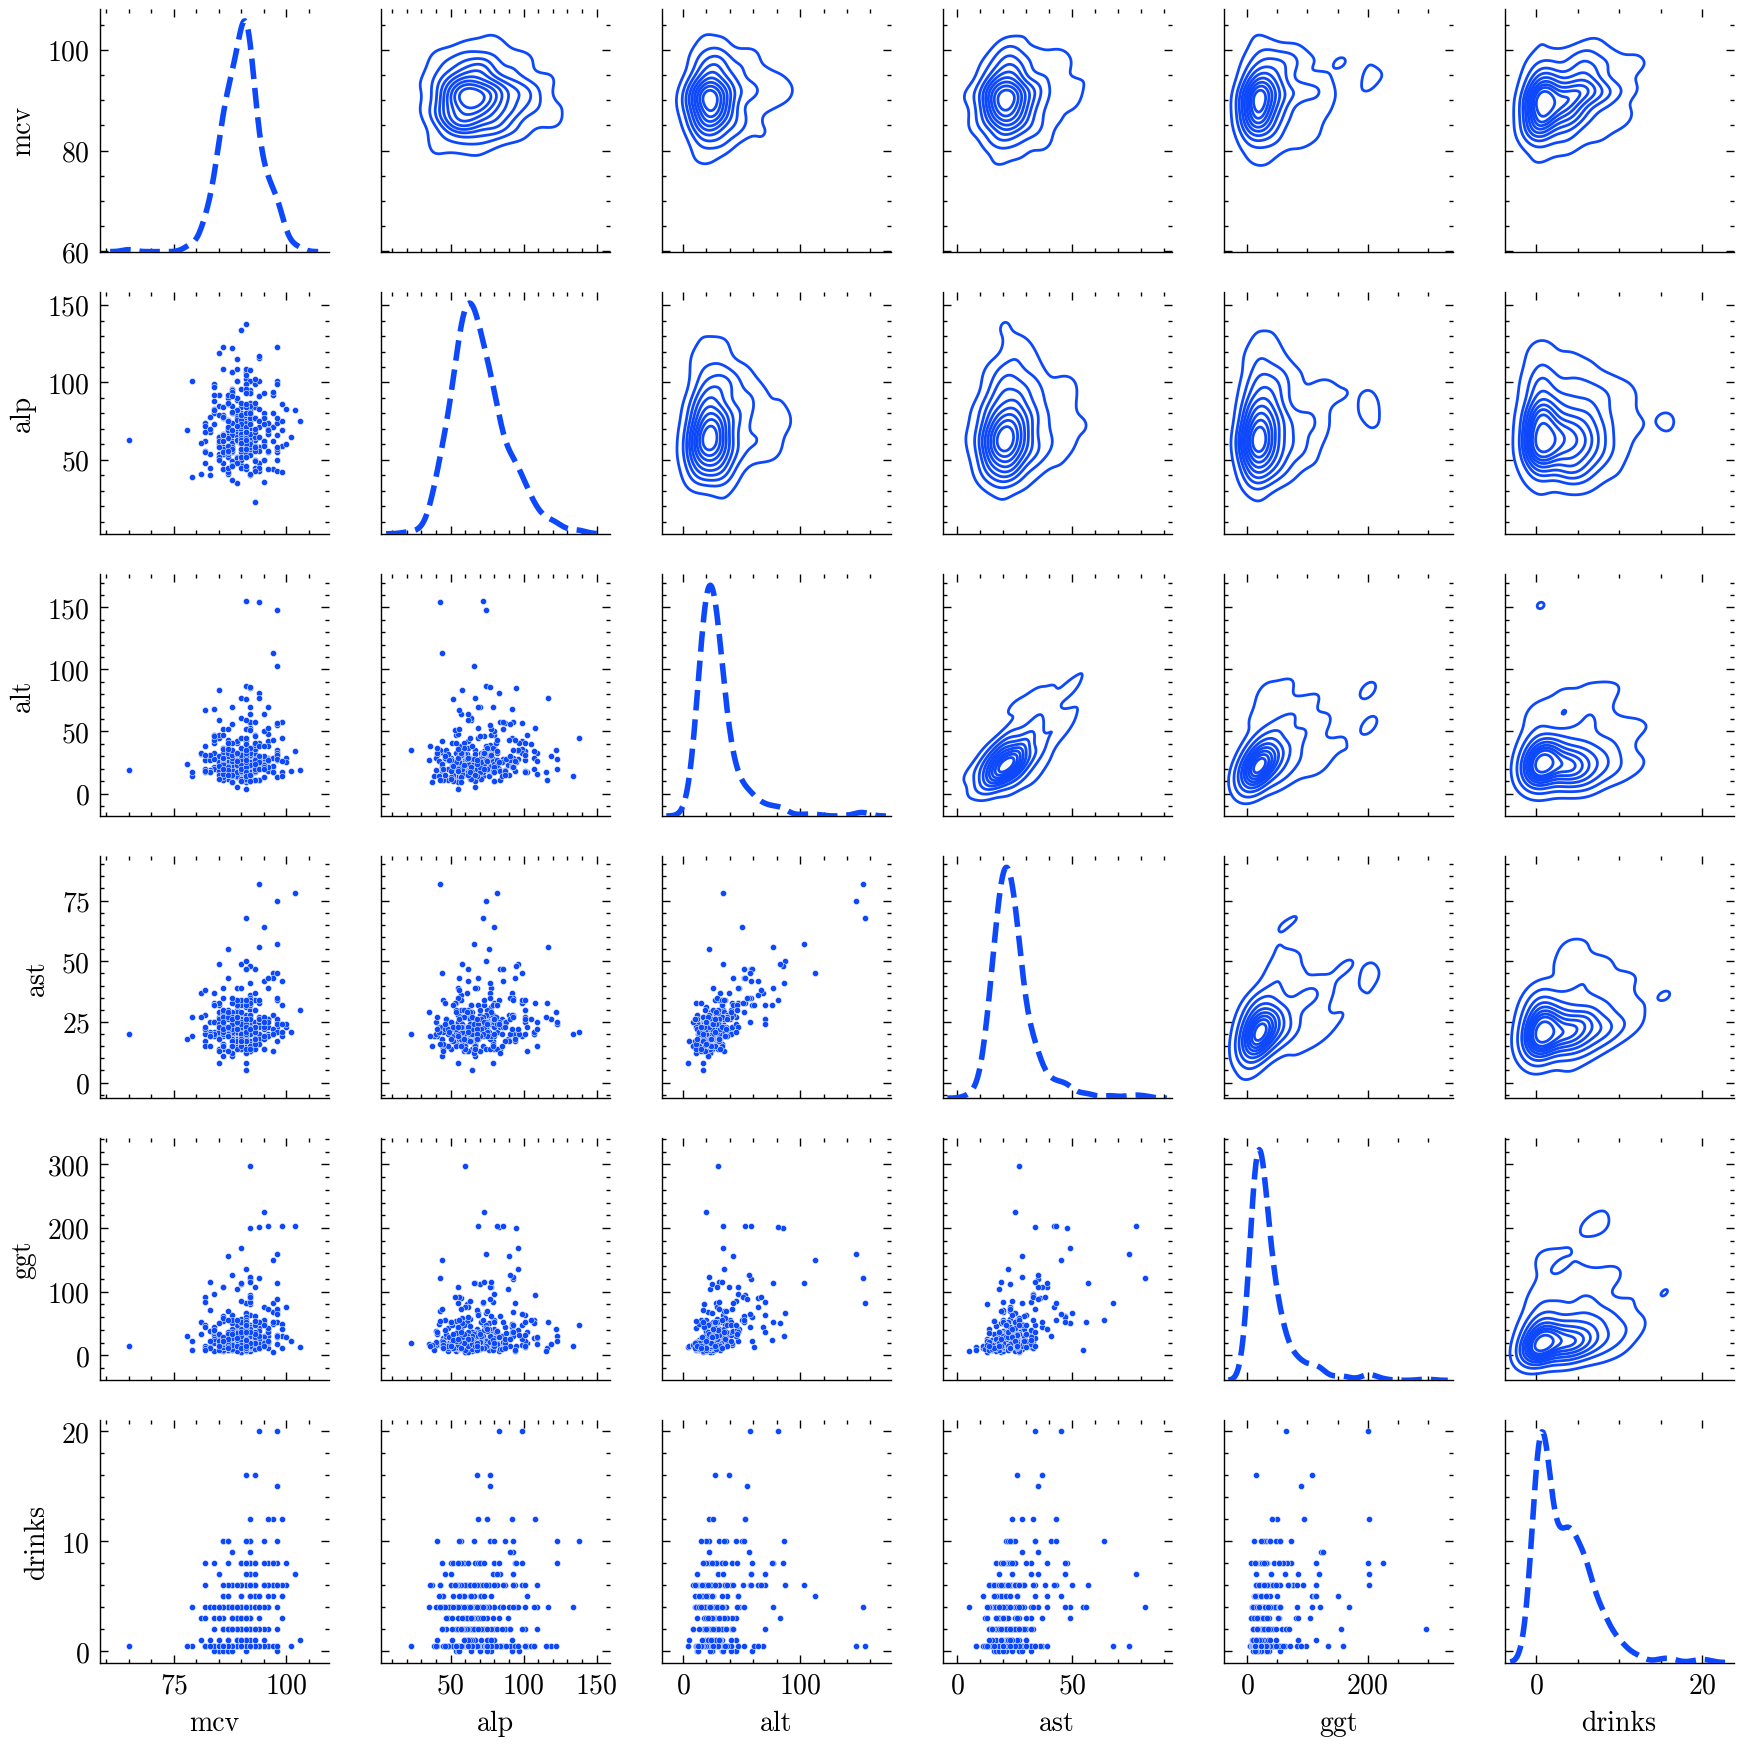

In [13]:
g = sns.PairGrid(liver_disorders, diag_sharey=False, height=1.5)
g.map_lower(sns.scatterplot, s=5)
g.map_upper(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
plt.show()

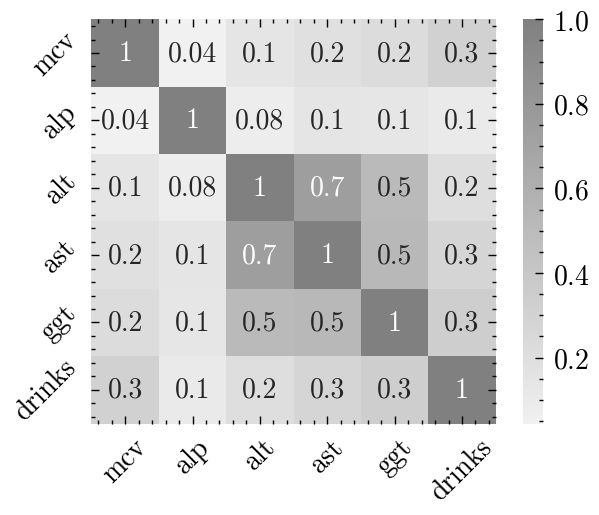

In [14]:
# Generate a heatmap of feature correlation
sns.heatmap(liver_disorders.corr(), cmap=sns.color_palette("light:gray", as_cmap=True), 
            square=True, cbar=True, annot=True, fmt='.1g')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

* AST and ALT have a pretty high association which could violate GLM no-colliniarity assumption
* GGT appears to be associated with AST and ALT
* MCV has the strongest association with the target feature

Since AST and ALT are correlated pretty closely, they may cause some issues in a GLM but it is know that ALT/AST ratio is an important indicator of alcohol liver damage and could point to cirrhosis ([source](https://pubmed.ncbi.nlm.nih.gov/3135226/#:~:text=In%20addition%2C%20the%20use%20of%20the%20AST/ALT,less%20helpful%20in%20the%20presence%20of%20cirrhosis.)). We can potentially drop one of AST and ALT and add their ratio instead. 

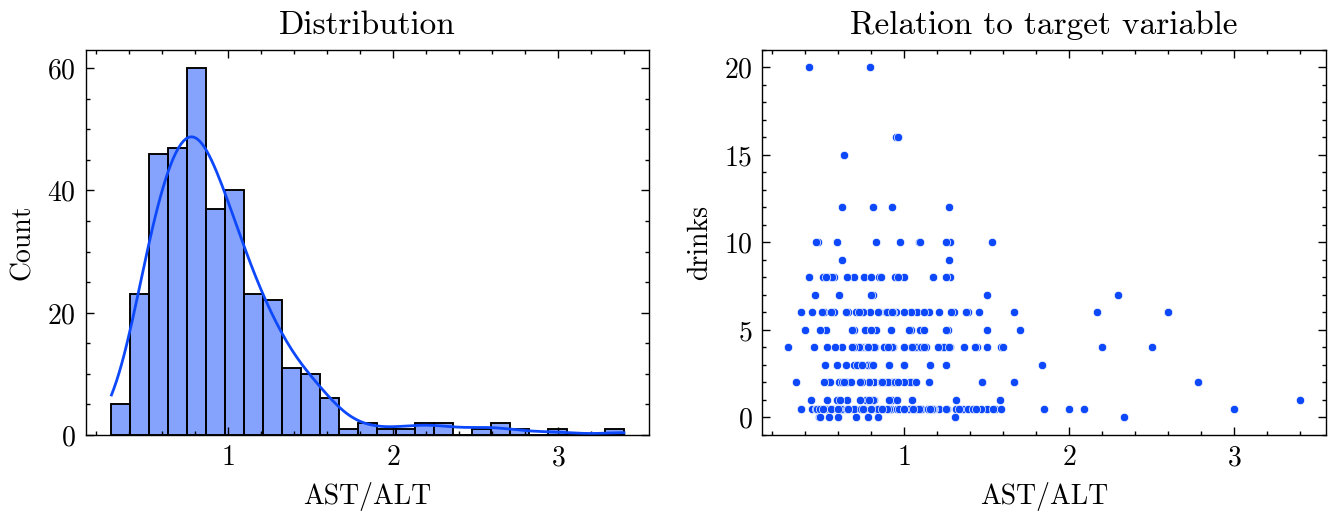

In [15]:
ast_alt = liver_disorders['ast'] / liver_disorders['alt']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 2.5))

sns.histplot(x=ast_alt, kde=True, ax=ax1)
ax1.set_xlabel('AST/ALT')
ax1.set_title('Distribution')

sns.scatterplot(x=ast_alt, y=liver_disorders[target], ax=ax2)
ax2.set_xlabel('AST/ALT')
ax2.set_title('Relation to target variable')

plt.show()

* It looks like there instances where AST/ALT ratio is high but it doesn't seem to be associated with very high drink counts
* Likewise, the instances where drinks is high but AST/ALT is about average

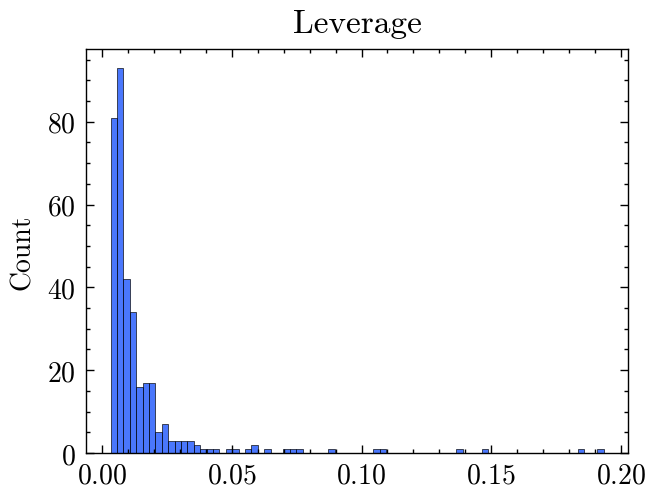


average leverage: 0.014
count high leverage points above 3x mean: 17
count high leverage points above 2x mean: 28


In [16]:
# let's take a look at points of high leverage - these cause poor performance in GLM and should be removed

X = liver_disorders[data_features].to_numpy()
hat = X @ np.linalg.inv(X.T @ X) @ X.T
leverage = np.diag(hat)

sns.histplot(leverage)
plt.title('Leverage')
plt.show()

print(f"\naverage leverage: {np.mean(leverage):.3f}")
print(f"count high leverage points above 3x mean: {np.sum(leverage>3*np.mean(leverage))}")
print(f"count high leverage points above 2x mean: {np.sum(leverage>2*np.mean(leverage))}")

* There are definitely points of high leverage. According to this source from PSU, high leverage points over three times the mean value are removed by minitab but some people use a factor of 2 instead ([source](https://online.stat.psu.edu/stat501/book/export/html/973#:~:text=we%20see%20that%20as%20we,the%20third%20property%20mentioned%20above.)). In this case, removing high leverage points > 2x the mean would remove almost 10% of all data so let's use 3x instead. 

In [18]:
# do linear relationships between the predictors show any pattern?

pca = PCA(n_components=2)
pca_components = pca.fit_transform(liver_disorders[data_features])

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

PCA explained variance ratio: [0.71568199 0.13846657]


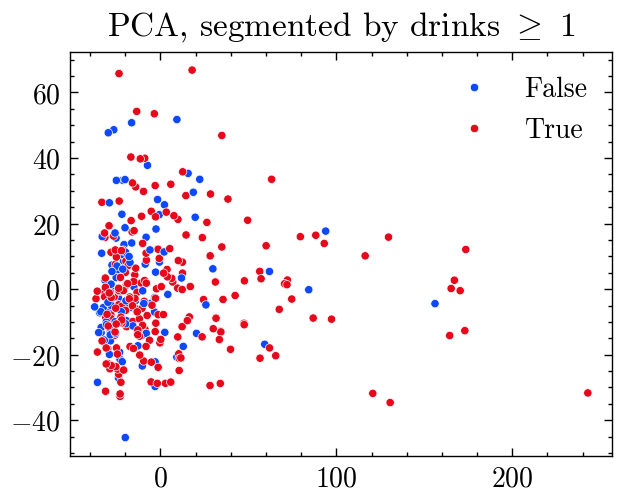

In [21]:
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=liver_disorders[target]>=1)
plt.title('PCA, segmented by drinks $\geq$ 1')
plt.legend()
plt.show()

* Linear decomposition of features does not show any clear pattern between samples where drinks $\geq$ 1

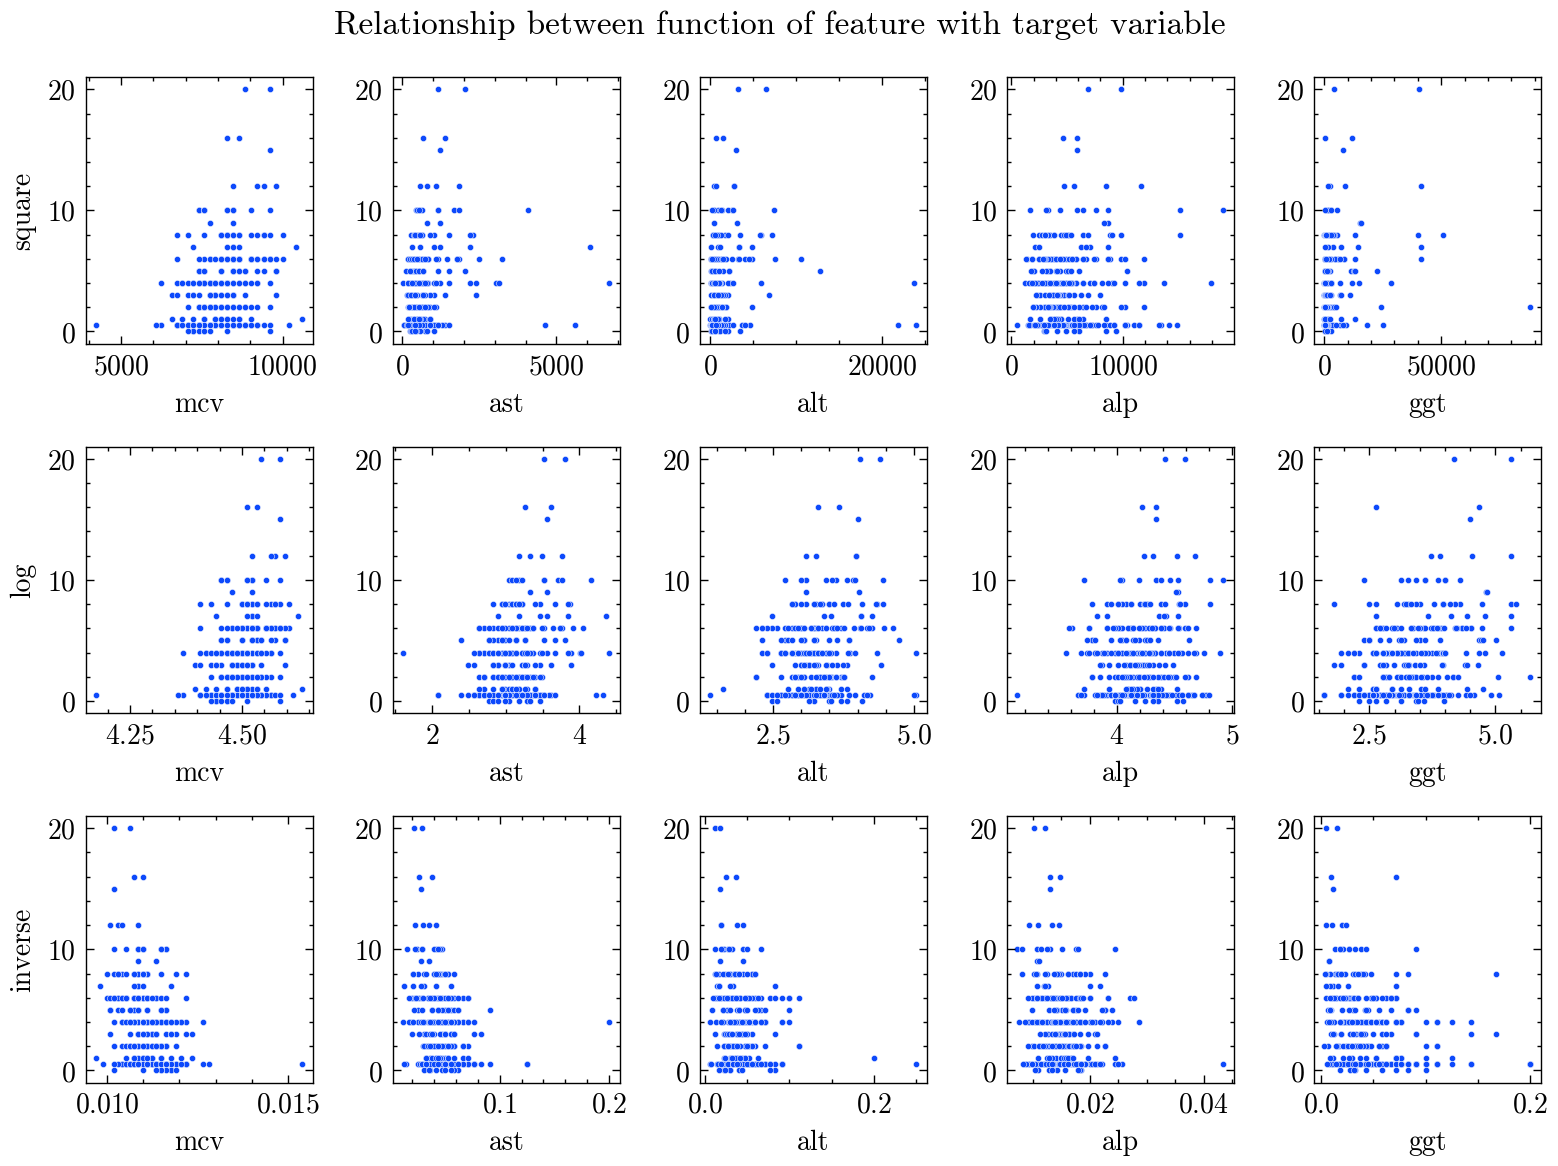

In [22]:
# let's see if modification of features can capture a relationship with drinks target

new_features = [np.square(liver_disorders[f]) for f in ['mcv', 'ast', 'alt', 'alp', 'ggt']]
new_features += [np.log(liver_disorders[f]) for f in ['mcv', 'ast', 'alt', 'alp', 'ggt']]
new_features += [liver_disorders[f].apply(lambda x: 1/x) for f in ['mcv', 'ast', 'alt', 'alp', 'ggt']]

fns = ['square', 'log', 'inverse']

fig, axes = plt.subplots(nrows=len(fns), ncols=5, figsize=(8, 6))

for i, f in enumerate(new_features):
    ax = axes[np.floor(i/5).astype(int)][i%5]
    sns.scatterplot(x=f, y=liver_disorders['drinks'], ax=ax, s=5)
    ax.set_ylabel('')
    if i%5 == 0:  # first column
        ax.set_ylabel(fns[i//5])

plt.suptitle('Relationship between function of feature with target variable')
plt.tight_layout()
plt.show()

* Inverse of MCV and AST both have pretty linear negative relationship with drinks
* Log of AST appears to have a positive linear relationship with drinks but the inverse appears to have a tighter variance

## Preprocessing

In [23]:
# create a reusable preprocessing function so we can reuse it if we need to later

def feature_engineering(features_df: pd.DataFrame):
    """
    Function which performs feature engineering 

    Inputs:
        features_df: dataframe with original features
    
    Feature engineering:
        1. Add AST / ALT ratio: ast_alt_ratio
        2. Remove ALT from features since ast and alt are highly correlated
        
    Returns:
        np.array of predictors
        np.array of processed features
        
    """

    df = features_df.copy()  # to be safe

    # add ALT/AST ratio and remove ALT (since AST is known to be more indicative of alcohol liver damange)
    df['ast_alt'] = df['ast'] / df['alt']    

    # remove alt since we are keeping ast and ast and alt are highly correlated
    features = [f for f in df.columns if f not in ['alt']]  

    return df[features], features
    

In [24]:
# select and preprocess data

y = liver_disorders[target].to_numpy()
X_df, features = feature_engineering(liver_disorders[data_features])

print(f"final features: {', '.join(features)}")

final features: mcv, alp, ast, ggt, ast_alt


In [28]:
# train / test split (let's use 30% for test set)
# since it appears that our sample was selected by # of tests 
# that an individual had w/in normal range, 
# let's stratify by # of normal test scores
X_train, X_test, y_train, y_test = train_test_split(X_df.to_numpy(), y, test_size=0.2, 
                                                    random_state=128, stratify=normal_test_score)

# identify and remove points of high leverage from training data
leverage = np.diag(X_train @ np.linalg.inv(X_train.T @ X_train) @ X_train.T)  # diagonal of hat matrix
leverage_filter = leverage <= 2 * np.mean(leverage)

X_train, y_train = X_train[leverage_filter], y_train[leverage_filter]

print(f"samples in training set: {len(X_train)}")
print(f"samples in test set: {len(X_test)}")

samples in training set: 249
samples in test set: 69


## Linear Regression Model

Since one of the goals of this project is to assess which liver function tests are able to distinguish how much individuals drink, we can use a GLM since its feature importance is easy to interpret.

* As mentioned in the EDA, Poisson and Gamma regression assumptions may be violated if we use either regression to predict the target feature (namely, target variable as Poisson would be overdisperesed and the dataset has zeros which are not defined in the Gamma distribution).
* Both, linear regression and logistic regression could work but there are downsides to each:
    * Linear regression could yield negative values or fractions that would require handling
    * Logistic regression may lead to loss of information and there is no exact way to determine the drinks threshold.
    
As noted in EDA, our dataset contains healthy individuals, those who suffer from alcohol-related liver damage, and those whose liver damages has other causes. Alcohol-related liver damage is not mutually exclusive with other causes either. This all complicates our ability to classify drinking as opposed to predicting amount, given test results. Therefore, let's proceed with a linear regression model and do some post-processing to ensure that our assumptions about the target variable are satisfied. Namely, if predictions are negative - assume them to be 0 and if predictions represent a fraction then we will round them to the nearest half or whole number. 

The baseline model will work on original features so we can see if any feature engineering is necessary. 

In [29]:
# HELPER FUNCTIONS

# standard error function to help calculate studentized residuals
stderr = lambda arr: np.std(arr) / np.sqrt((len(arr)-1) / len(arr))  


In [30]:
# we need to postprocess the data since our target can't have negatives
# we will also round to the nearest half value 

def postprocess(model_predictions: np.array):
    """
    Performs post processing on model predictions to align the data with assumptions:
        1. If value < 0, change it to 0
        2. If value is <1, round to nearest half, otherwise round to whole number

    Returns: 
        predictions: np.array
    
    """
    proc_predictions = model_predictions.copy()

    # replace neg values with 0
    proc_predictions = np.where(proc_predictions<0, 0, proc_predictions)

    # round values
    proc_predictions = np.where(proc_predictions>1, np.round(proc_predictions), np.round(2 * proc_predictions)/2)

    return proc_predictions
    

In [33]:
# let's create a baseline model 

# create a pipeline with scaling so we don't accidentally leak info
# let's use stanard scaler since most of the features are about normally distributed

model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [34]:
# do cross validation training with 5 validation sets

cv = cross_validate(model, X_train, y_train, cv=5)

print(f"Cross-validation R2: {np.mean(cv['test_score']):.4f} ({np.round(cv['test_score'], 3)})")

Cross-validation R2: 0.1441 ([-0.088  0.165  0.302  0.09   0.252])


In [35]:
# calculate predictions and residuals

predictions = postprocess(model.predict(X_train))

residuals = y_train - predictions
studentized_residuals = residuals / stderr(residuals)

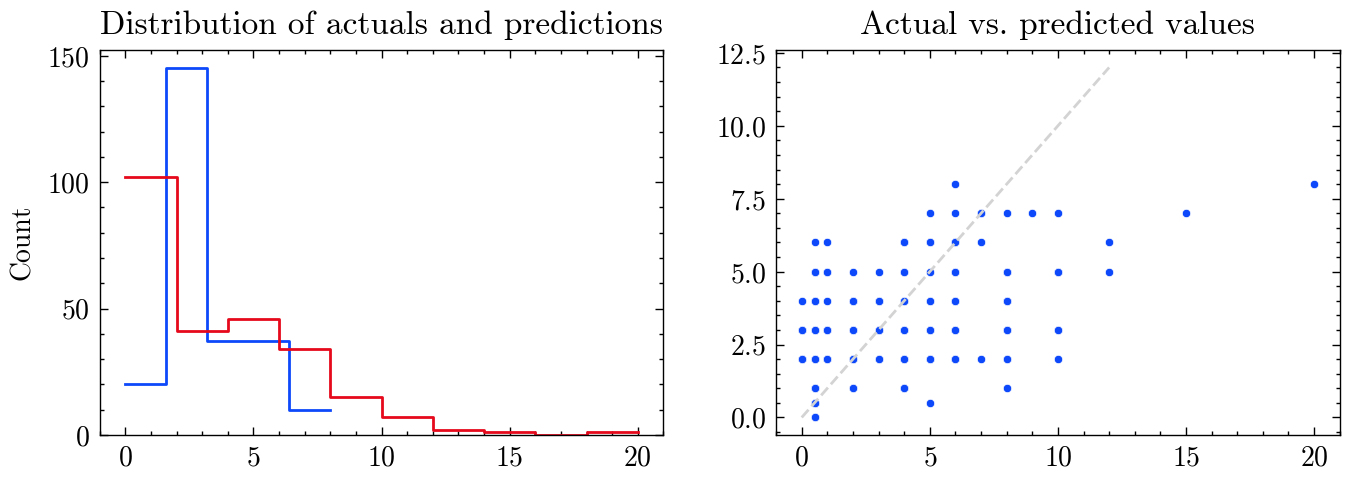

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 2.5))

sns.histplot(predictions, ax=ax1, element='step', label='predictions', fill=False, linestyle='-', bins=5)
sns.histplot(y_train, ax=ax1, element='step', label='actuals', fill=False, linestyle='-', bins=10)
ax1.set_title('Distribution of actuals and predictions')

sns.scatterplot(x=y_train, y=predictions, ax=ax2)
sns.lineplot(x=np.linspace(0, 12, 2), y=np.linspace(0, 12, 2), ax=ax2, color='lightgray', linestyle='--')
ax2.set_title('Actual vs. predicted values')

plt.show()

* Unfortunately, the model doesn't seem to predict the target variable well - the distribution doesn't match and it overestimates low values and underestimates large values.

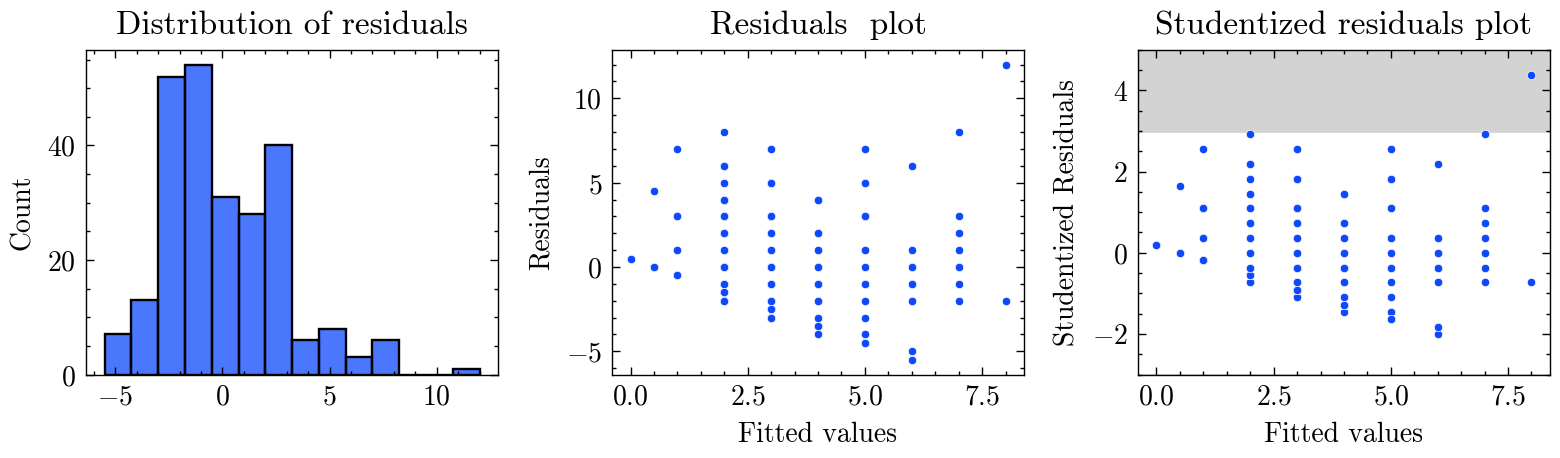

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 2.5))

sns.histplot(residuals, ax=ax1)
ax1.set_title('Distribution of residuals')

sns.scatterplot(x=predictions, y=residuals, ax=ax2)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals  plot')

ax3.axhspan(-3, -5, color='lightgray')
ax3.axhspan(3, 5, color='lightgray')
sns.scatterplot(x=predictions, y=studentized_residuals, ax=ax3)
ax3.set_xlabel('Fitted values')
ax3.set_ylabel('Studentized Residuals')
ax3.set_title('Studentized residuals plot')
ax3.set_ylim(-3, 5)

plt.tight_layout()
plt.show()

* The model doesn't perform well on train data
* The CV R2s are all over the place and even have some negative valus
* Distribution of residuals shows that there are likely outliers. We can also see this from the studentized residuals plot - it should be fair to remove any y value where the absolute value of studentized residual is > 3
* Residuals definitely have a negative correlation with target variable as observed in the plot above

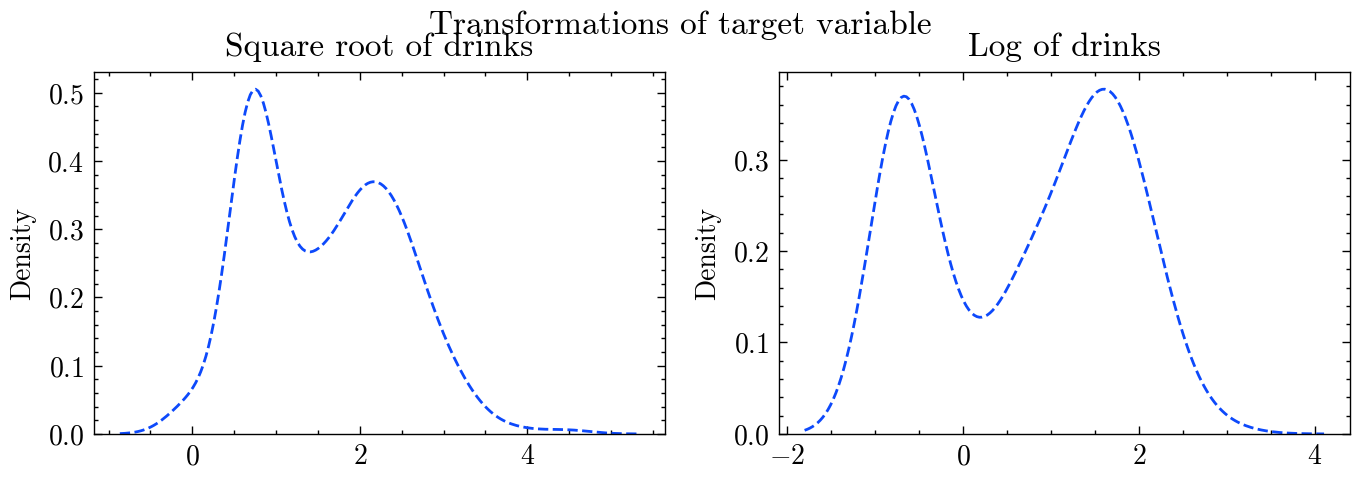

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7, 2.5))

sns.kdeplot(np.sqrt(y_train), ax=ax1)
ax1.set_title('Square root of drinks')

sns.kdeplot(np.log(y_train[y_train>0]), ax=ax2)
ax2.set_title('Log of drinks')

plt.tight_layout()
plt.suptitle('Transformations of target variable')
plt.show()

* Transforming the y variable has its own problems since it creates a bimodal distribution

Ultimately, predicting person's drinking from their liver function tests is a two-fold problem:
1. Does the person drink at all?
2. If the person drinks, do they drink enough to impact their results?

There are definitely individuals whose drinking may not be observed via liver tests and there are individuals whose liver function may be poor due to factors other than drinking. 

In [41]:
# we saw that cv errors have a high range and can be negative so test r2 is unlikely to be deterministic of true test r2

print(f"Test R2: {r2_score(postprocess(model.predict(X_test)), y_test)}")

Test R2: -0.7761050931844178


Overall, this model performs very poorly and it may not be a good fit for the task at hand. Let's explore some other options. 

## Logistic Regression

To keep things simple (but hopefully not too simple), we can transform the output feature and employ a logistic regression to attempt the prediction. 

We will need to figure out the right threshold $k$ to cap off drinks variable. We could determine this heuristically but instead, let's compare how a model performs at each $k$. Let's assume that $k$ is the upper limit of moderate drinking and values $>k$ indicate heavy drinking.

We will want to select a $k$ that we maximize specificity and sensitivity. 


In [42]:
# HELPER FUNCTIONS

# define a function to binarize target variable based on some upper threshold
binarize_y = lambda y, k: np.where(y<=k, 0, 1)

# calculate sensitivity and specificity
# sensitivity = tp / (tp + fn) = tp / all positive = where y_true = 1 and y_pred = 1 / all y_true = 1
# specificity = tn / (fp + tn) = tp / all neg = where y_true = 0 and y_pred = 0 / all y_true = 0
get_sensitivity = lambda y_true, y_pred: np.sum(y_true * y_pred) / np.sum(y_true) if np.sum(y_true)>0 else 0
get_sensitivity_score  = make_scorer(get_sensitivity, greater_is_better=True, response_method='predict')

inv_label = lambda y: np.where(y==1, 0, 1)
get_specificity = lambda y_true, y_pred: np.sum(inv_label(y_true) * inv_label(y_pred)) / np.sum(inv_label(y_true))
get_specificity_score  = make_scorer(get_specificity, greater_is_better=True, response_method='predict')

In [43]:
# generate a list of candidate thresholds
thresholds = np.linspace(min(y_train), max(y_train), max(y_train).astype(int)+1)

In [44]:
# initiate logistic regression without regularization

model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(penalty=None, solver='lbfgs'))
])


In [45]:
# iterate through possible values of k in the train data and assess the model

ks = []  # to log thresholds
sensitivity = []
specificity = []

CV = 3

for k in thresholds:
    
    # binarize the target variable based on threshold k and fit the model
    y_train_bin = binarize_y(y_train, k)
    if len(np.unique(y_train_bin))==1:
        continue  # skip if there's only one class

    # we need at least |cv| samples in each class
    if np.sum(y_train_bin==0)<CV or np.sum(y_train_bin==1)<CV:
        continue

    # perform cross validation 
    cv = cross_validate(estimator=model, X=X_train, y=y_train_bin, cv=3,
                        scoring={'sensitivity': get_sensitivity_score, 'specificity': get_specificity_score})

    # log model evaluation
    sensitivity.append(cv['test_sensitivity'])
    specificity.append(cv['test_specificity'])
    ks.append(k)
    

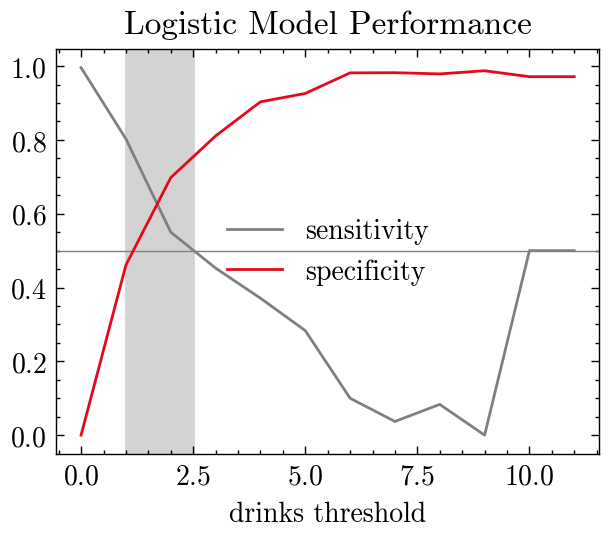

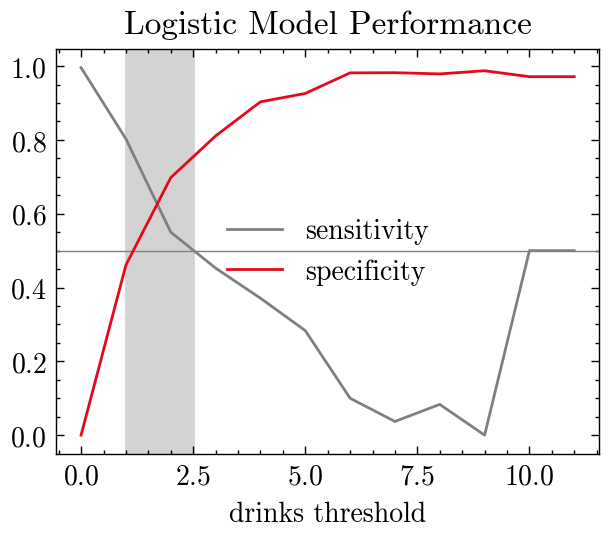

In [58]:
fig, ax = plt.subplots()

plt.axhline(0.5, color='gray', lw=0.5)
plt.axvspan(1, 2.5, color='lightgray')

sns.lineplot(x=ks, y=np.mean(sensitivity, axis=1), label='sensitivity', color='gray')
sns.lineplot(x=ks, y=np.mean(specificity, axis=1), label='specificity')

plt.xlabel('drinks threshold')
plt.title('Logistic Model Performance')

plt.savefig('../images/logistic_results.png')
plt.show()

The model's performance looks fairly good!

There are two risks that we are weighing:
1. The risk of not providing key resources regarding reversing liver disease to those whose lives can be saved: we shouldn't set the threshold too high
2. The risk of assuming that liver disease is caused by moderate alcohol consumption when other factors may be in play: we should set the threshold too low

At upper threshold of drinks between 1 and 2, both metrics are about greater than 50%. At 3, both are definitevely greater than 50% even though sensitivity is lower than specificity. 

Let's use threshold of 2 as this counts as one full drink as is also on par with CDC moderate drinking guidelines for men (however, our data may be measuring drinks as British pints which are larger than American pints).
    
Both metrics are also greater than 50% at the very tail end when drinks are greater than about 10. The issue, however, is that support when drinks > 10 is very low so yes - we can identify individuals who dirnk > 10 drinks well but there are very few of them. 

In [52]:
k = 2

y_train_bin = binarize_y(y_train, k)
model.fit(X_train, y_train_bin)

confusion_matrix(y_train_bin, model.predict(X_train), labels=[1, 0])

array([[67, 53],
       [33, 96]])

In [53]:
y_test_bin = binarize_y(y_test, k)
predictions = model.predict(X_test)

confusion_matrix(y_test_bin, predictions, labels=[1, 0])

array([[22, 18],
       [ 8, 21]])

In [63]:
print(f"Test sensitivity: {get_sensitivity(y_test_bin, predictions):.4g}")
print(f"Test specificity: {get_specificity(y_test_bin, predictions):.4g}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test_bin, predictions):.4g}")

Test sensitivity: 0.55
Test specificity: 0.7241
Test balanced accuracy: 0.6371


* If the moderate drinking threshold we set is 2 then we can identify a bit more than half of individuals who drink 3+ half-pints per day and 70% of individuals who drink <3 half-pints per day
* Among individuals that we categorize as heavy drinkers based on liver function test results, we will be correct also 2/3 of the time. 

These results are pretty good.

Our linear model $R^2$ (or the proportion of overall variance in drinks that the model could explain) was in negatives for some cross validation folds. That means that the model performed worse than a random guess. But the logistic regression model sensitivity and specificy are both > 0.5 for some $k$s which means this model is able to perform better than a random guess. 

Let's use it to assess feature importance. 

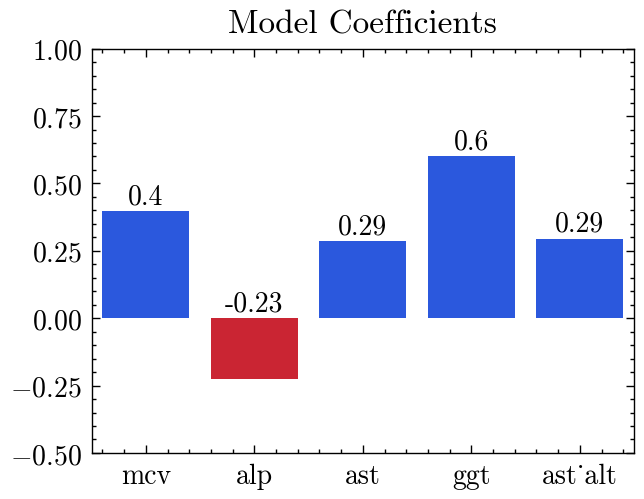

In [64]:
coefficients = model.named_steps['classifier'].coef_[0]

sns.barplot(x=features, y=coefficients, hue=coefficients<0)
plt.ylim(-0.5, 1)
for i, f in enumerate(features):
    plt.annotate(text=f"{coefficients[i]:.2g}", 
                 xy=(i, coefficients[i]), 
                 xytext=(i, np.where(coefficients[i]>0, coefficients[i]+0.03, 0.03)),
                 ha='center')
plt.title('Model Coefficients')
plt.legend().set_visible(False)

plt.savefig('../images/model_coefficients.png')
plt.show()

* Coefficients represent a change in the odds of regular consumption of 3+ drinks when the predictors increases by one standard score (since we scaled the input), while holding all other variables constant
* GGT definitely dominates feature importance, followed closely by MCV, AST, and AST/ALT ratio
* ALP actually has an inverse effect on target variable, all other factors considered

This is definitely curious. According to this model, if we account for all other liver function tests, a higher ALP does not indicate that the person is a heavy drinker. At the same time, ALP is representative liver damage but may also indicate issues with other organs as well. This could mean that given that other liver function tests (accounted for here) come back normal, an increase in ALP could be associated with liver damage which is not due to alcohol and further testing should be done to rule out other diseases. 

## Remarks

In this project, I investigated if we can predict patient's alcohol consumption from the results of their liver function tests. I used the BUPA liver disorders dataset which includes >300 samples of data for men and was devised in 1980s. The dataset was likely compiled together based on how many liver function tests a person passed. Liver function testss include MCV, ALP, AST, ALT, and GGT. 

Knowing that AST/ALT ratio plays a role in identifying alcohol-induced liver damange, I added that as a feature and removed ALT so that we don't violate GLM assumptions. Samples are also scaled using a normal scaler in a preprocessing step. 

It was determined that a Poisson regression or a Gamma regression would not work on the dataset we have as model assumptions would be violated. A linear regression model was unfortunately not a good fit for the data. The CV results were very volatile and included negative values. Test R2 score was very poor indicating that the model does not generalize. The difficulty with logistic regression is that we don't have a very clear way of selecting a threshold that would help distinguish moderate vs. heavy drinking. Therefore, a range of threshold values was evaluated. 

I found that upper limit of 2 half-pints (or one full pint) per day was the optimal threshold for simultaneously maximizing sensitivity and specificity and ensuring that the model is able to perform better than a random guess. 

Most features are positively impactful to determining if a person is a moderate drinker or a heavy drinker with GGT being the best predictor. Other factors considered, one standard unit increase in GGT increases the chance that the person is a heavy drinker by 57%. Meanwhile, ALP is actually a negative predictor - a person is less likely to be a drinker if their ALP is higher, given other tests don't indicate alcohol liver damage. This could be investigated further via analysis of ALP pathophysiology. 

There are several limitations in this project:
* We don't know how the data was collected and if there are biases that would prevent this model from generalizing (e.g. if the samples represent one specific ethnicity, it may not generalize to all humans)
* We are missing many confounding variables, including demographics which may be impactful
* We don't know if a person has alcohol-induced liver damage
* It's likely that results of medical tests have some complex relationship
* We can't know if target variable is correctly reported by participants and by BUPA
* We don't know how long the person has been drinking and what their drinking pattern is and if it impacts liver function
* We don't have units for any of the features and made assumptions regarding the units

Due to numerous limitations of this study, there are several opportunities for improvement in this project and some include:
* Including demographic data and more confounders could improve results and analysis signficantly
* In leiu of Poisson regression, we could try Negative Binomial regression to predict drinks count
* Including identification of alcohol-induced liver damage instead of drinks can help improve the model
